In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import sys
import random
import math
import time

# Soluciones Iniciales

In [17]:
df_aristas = pd.read_csv("data-ejemplo/aristas.csv")
df_aristas

,id,source,target,length,foot,car_forward,car_backward,bike_forward,bike_backward,wkt
0,104851469,1209261299,5394543995,147.433722,1,4,0,2,0,"LINESTRING(-75.2164990 -12.0585078, -75.216908..."
1,104851469,5394543995,4150228762,123.394352,1,4,0,2,0,"LINESTRING(-75.2172212 -12.0573874, -75.217328..."
2,104851469,4150228762,1209256646,86.068643,1,4,0,2,0,"LINESTRING(-75.2178111 -12.0564409, -75.218202..."
3,104851469,1209256646,5394544018,99.195577,1,4,0,2,0,"LINESTRING(-75.2182021 -12.0557689, -75.218673..."
4,104851469,5394544018,1043251501,701.253849,1,4,0,2,0,"LINESTRING(-75.2186738 -12.0550065, -75.219140..."
...,...,...,...,...,...,...,...,...,...,...
79,559267886,1209259338,5394543998,100.946930,1,1,1,2,2,"LINESTRING(-75.2195249 -12.0565551, -75.219046..."
80,559267887,5394544004,5394544003,56.109782,1,1,1,2,2,"LINESTRING(-75.2214079 -12.0570883, -75.221091..."
81,559267888,5394544009,5394544007,107.215487,1,1,1,2,2,"LINESTRING(-75.2213640 -12.0581984, -75.220599..."
82,559267888,5394544007,5394544005,108.105147,1,1,1,2,2,"LINESTRING(-75.2205667 -12.0576398, -75.220514..."


In [18]:
df_vertices = pd.read_csv("data-ejemplo/nodos.csv")
df_vertices

,id,lon,lat
0,1209250656,-75.217439,-12.055316
1,1209259338,-75.219525,-12.056555
2,5394543995,-75.217221,-12.057387
3,1209256161,-75.219088,-12.056291
4,5394543983,-75.220496,-12.056532
...,...,...,...
57,5394544003,-75.221092,-12.057486
58,5394543993,-75.220840,-12.059021
59,5394543977,-75.218573,-12.056720
60,5394544001,-75.219448,-12.057576


In [19]:
class Vertex:
    def __init__(self, node,lon,lat,cont):
      rand = random.randrange(9000,100000)
      self.id = node
      self.adjacent = {}
      # Distancia infinito para todos los nodos (infinito es un random grande)
      self.distance = rand
      self.distanceG = rand
      self.distanceF = rand
      # Todos los nodos inician como no visitados    
      self.visited = False  
      # prev
      self.previous = None
      #longitud y latitud
      self.longitud = lon
      self.latitud = lat
      self.cont = cont #identificador unico para cada vertice (a parte del id)

    def agregar_vecino(self, neighbor, weight=0):
      self.adjacent[neighbor] = weight

    def obtener_conexiones(self):
      return self.adjacent.keys()  

    def obtener_id(self):
      return self.id

    def obtener_peso(self, neighbor):
      return self.adjacent[neighbor]

    def agregar_distancia(self, dist):
      self.distance = dist

    def obtener_distancia(self):
      return self.distance

    def agregar_distanciaG(self, dist):
      self.distanceG = dist

    def obtener_distanciaG(self):
      return self.distanceG

    def agregar_distanciaF(self, dist):
      self.distanceF = dist

    def obtener_distanciaF(self):
      return self.distanceF

    def obtener_lon(self):
      return self.longitud

    def obtener_lat(self):
      return self.latitud

    def agregar_previous(self, prev):
      self.previous = prev

    def visitado(self):
      self.visited = True

    def __str__(self):
      return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])

class Graph:
  def __init__(self):
    self.vert_dict = {}
    self.num_vertices = 0

  def __iter__(self):
    return iter(self.vert_dict.values())

  def agregar_vertice(self, node,lon,lat,cont):
    self.num_vertices = self.num_vertices + 1
    new_vertex = Vertex(node,lon,lat,cont)
    self.vert_dict[node] = new_vertex
    return new_vertex

  def obtener_vertice(self, n):
    if n in self.vert_dict:
      return self.vert_dict[n]
    else:
      return None

  def agregar_arista(self, frm, to, cost = 0):
    if frm not in self.vert_dict:
      self.agregar_vertice(frm)
    if to not in self.vert_dict:
      self.agregar_vertice(to)

    self.vert_dict[frm].agregar_vecino(self.vert_dict[to], cost)
    self.vert_dict[to].agregar_vecino(self.vert_dict[frm], cost)

  def obtener_vertices(self):
    return self.vert_dict.keys()
  
  def obtener_vertices_nodes(self):
    return self.vert_dict.values()

  def agregar_previous(self, u):
    self.previous = u

  def obtener_previous(self, u):
    return self.previous

In [20]:
#N = Número de individuos
# G = Grafo
#s = nodo inicial
#t = nodo final
def esBucle(nodo):
  banderas = []
  adyacentes = nodo.obtener_conexiones()
  for adyacente in adyacentes:
    if adyacente.visited == True:
      banderas.append(True)
    else: banderas.append(False)
  if(len(banderas) == 1): return banderas[0]
  for i in range(len(banderas) - 1):
    if(i == 0):
      respuesta = banderas[i] and banderas[i+1]
    else:
      respuesta = respuesta and banderas[i+1]
  return respuesta

In [21]:
def poblacionInicial(N, s, t, G):
    poblacion = []
    for i in range(N):
        actual = s
        individuo = []
        individuo.insert(0,s)
        actual.visited = True
        while(actual != t):
            adyacentes = list(actual.obtener_conexiones())
            nodo = random.choice(list(adyacentes))
            if(esBucle(nodo) and nodo != t):
                nodo.visited = True
            if(nodo.visited == False):
                if(actual not in individuo):
                    individuo.append(actual)
                individuo.append(nodo)
                nodo.visited = True
                actual = nodo
            if(esBucle(actual) and actual != t):
                actual.visited = True
                actual = individuo.pop()
        poblacion.append(individuo)
        for vertice in list(G.obtener_vertices_nodes()):
            vertice.visited = False
    return poblacion

In [22]:
def f(x):
    return x
def fitness(individuo):
    suma = 0
    for i in range(len(individuo) - 1):
        suma = suma + individuo[i].obtener_peso(individuo[i+1])
    return suma

In [23]:
g = Graph()
g.agregar_vertice(1, 0, 0, 0)
g.agregar_vertice(2, 0, 0, 1)
g.agregar_vertice(3, 0, 0, 2)
g.agregar_vertice(4, 0, 0, 3)
g.agregar_vertice(5, 0, 0, 4)
g.agregar_vertice(6, 0, 0, 5)
g.agregar_vertice(7, 0, 0, 6)
g.agregar_vertice(8, 0, 0, 7)

#source, target, longitud de la arista
g.agregar_arista(1,2,3)
g.agregar_arista(1,3,3)
g.agregar_arista(2,3,1)
g.agregar_arista(2,4,2)
g.agregar_arista(3,4,5)
g.agregar_arista(4,5,1)
g.agregar_arista(4,6,3)
g.agregar_arista(5,6,4)
g.agregar_arista(5,7,6)
g.agregar_arista(5,8,8)
g.agregar_arista(6,7,3)
g.agregar_arista(6,8,7)
g.agregar_arista(7,8,3)

poblacion = poblacionInicial(7,g.obtener_vertice(1), g.obtener_vertice(7), g)

for i, individuo in enumerate(poblacion):
    indiv = []
    print("individuo ",i,": ")
    for elemento in individuo:
        indiv.append(elemento.id)
    print(indiv)
    print(fitness(individuo))


individuo  0 : 
[1, 2, 3, 4, 6, 8, 7]
22
individuo  1 : 
[1, 2, 3, 4, 5, 8, 7]
21
individuo  2 : 
[1, 3, 4, 6, 8, 5, 7]
32
individuo  3 : 
[1, 2, 3, 4, 6, 7]
15
individuo  4 : 
[1, 2, 4, 5, 7]
12
individuo  5 : 
[1, 2, 4, 5, 6, 8, 7]
20
individuo  6 : 
[1, 3, 2, 4, 5, 8, 7]
18


In [24]:
g = Graph()
g.agregar_vertice(1, 0, 0, 0)
g.agregar_vertice(2, 0, 0, 1)
g.agregar_vertice(3, 0, 0, 2)
g.agregar_vertice(4, 0, 0, 3)
g.agregar_vertice(5, 0, 0, 4)
g.agregar_vertice(6, 0, 0, 5)
g.agregar_vertice(7, 0, 0, 6)
g.agregar_vertice(8, 0, 0, 7)
g.agregar_vertice(9, 0, 0, 8)
g.agregar_vertice(10, 0, 0, 9)
g.agregar_vertice(11, 0, 0, 10)
g.agregar_vertice(12, 0, 0, 11)
g.agregar_vertice(13, 0, 0, 12)
g.agregar_vertice(14, 0, 0, 13)
g.agregar_vertice(15, 0, 0, 14)
g.agregar_vertice(16, 0, 0, 15)
g.agregar_vertice(17, 0, 0, 16)
g.agregar_vertice(18, 0, 0, 17)
g.agregar_vertice(19, 0, 0, 18)
g.agregar_vertice(20, 0, 0, 19)
g.agregar_vertice(21, 0, 0, 20)
g.agregar_vertice(22, 0, 0, 21)

#source, target, longitud de la arista
g.agregar_arista(1,2,3)
g.agregar_arista(1,3,2)
g.agregar_arista(1,5,5)
g.agregar_arista(2,5,7)
g.agregar_arista(2,8,8)
g.agregar_arista(3,4,6)
g.agregar_arista(4,5,1)
g.agregar_arista(4,6,3)
g.agregar_arista(4,7,4)
g.agregar_arista(5,8,2)
g.agregar_arista(6,4,3)
g.agregar_arista(6,7,6)
g.agregar_arista(8,2,8)
g.agregar_arista(8,9,3)
g.agregar_arista(9,10,1)
g.agregar_arista(10,11,4)
g.agregar_arista(11,12,3)
g.agregar_arista(11,14,2)
g.agregar_arista(12,14,5)
g.agregar_arista(13,14,8)
g.agregar_arista(10,15,3)
g.agregar_arista(15,16,2)
g.agregar_arista(16,17,3)
g.agregar_arista(17,18,4)
g.agregar_arista(17,19,1)
g.agregar_arista(18,19,2)
g.agregar_arista(19,20,3)
g.agregar_arista(20,21,6)
g.agregar_arista(21,22,2)

poblacion = poblacionInicial(7,g.obtener_vertice(1), g.obtener_vertice(7), g)

for i, individuo in enumerate(poblacion):
    indiv = []
    print("individuo ",i,": ")
    for elemento in individuo:
        indiv.append(elemento.id)
    print(indiv)
    print(fitness(individuo))

individuo  0 : 
[1, 2, 8, 5, 4, 7]
18
individuo  1 : 
[1, 3, 4, 7]
12
individuo  2 : 
[1, 2, 8, 5, 4, 7]
18
individuo  3 : 
[1, 2, 5, 4, 6, 7]
20
individuo  4 : 
[1, 5, 4, 7]
10
individuo  5 : 
[1, 2, 8, 5, 4, 6, 7]
23
individuo  6 : 
[1, 5, 4, 7]
10


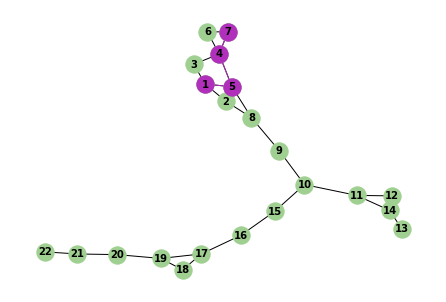

In [31]:
seed=699
options = {
    'node_color': '#A0D091',
    'node_size': 300,
    'width': 1,
    'font_weight': 'bold',
    'with_labels': True,
    'font_size': 10,
}
grafo = nx.Graph()
grafo.add_edge(1,2)
grafo.add_edge(1,3)
grafo.add_edge(1,5)
grafo.add_edge(2,5)
grafo.add_edge(2,8)
grafo.add_edge(3,4)
grafo.add_edge(4,5)
grafo.add_edge(4,6)
grafo.add_edge(4,7)
grafo.add_edge(5,8)
grafo.add_edge(6,4)
grafo.add_edge(6,7)
grafo.add_edge(8,2)
grafo.add_edge(8,9)
grafo.add_edge(9,10)
grafo.add_edge(10,11)
grafo.add_edge(11,12)
grafo.add_edge(11,14)
grafo.add_edge(12,14)
grafo.add_edge(13,14)
grafo.add_edge(10,15)
grafo.add_edge(15,16)
grafo.add_edge(16,17)
grafo.add_edge(17,18)
grafo.add_edge(17,19)
grafo.add_edge(18,19)
grafo.add_edge(19,20)
grafo.add_edge(20,21)
grafo.add_edge(21,22)
pos = nx.spring_layout(grafo,seed=seed)
nx.draw(grafo, pos = pos, **options)

color = "#B030BB"
for i, individuo in enumerate(poblacion):
    indiv = []
    for elemento in individuo:
        indiv.append(elemento.id)

lst_arist=[]
for t in range(len(indiv)-1):
  lst_arist.append((indiv[t],indiv[t+1]))
    
nx.draw_networkx_nodes(grafo,pos=pos, node_size=300, nodelist=indiv, node_color=color)
nx.draw_networkx_edges(grafo,pos=pos, edgelist=lst_arist, edge_color=color)
plt.show()

In [ ]:
vertices3 = pd.read_csv("mapas/mapa3/nodes3.csv")
aristas3 = pd.read_csv("mapas/mapa3/edges3.csv")

g = Graph()
for i in range(vertices3.shape[0]):
  g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

for j in range(aristas3.shape[0]):
  g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])

poblacion = poblacionInicial(5,g.obtener_vertice(7061771522), g.obtener_vertice(6381144732), g)

for i, individuo in enumerate(poblacion):
    indiv = []
    print("individuo ",i,": ")
    for elemento in individuo:
        indiv.append(elemento.id)
    print(indiv)
    print(fitness(individuo))

In [184]:
g = Graph()
for i in range(df_vertices.shape[0]):
  g.agregar_vertice(df_vertices["id"][i], df_vertices["lon"][i], df_vertices["lat"][i],i)

for j in range(df_aristas.shape[0]):
  g.agregar_arista(df_aristas["source"][j],df_aristas["target"][j],df_aristas["length"][j])
  
poblacion = poblacionInicial(4,g.obtener_vertice(5394544018), g.obtener_vertice(5394544016),g)
for i, individuo in enumerate(poblacion):
    indiv = []
    print("individuo ",i,": ")
    for elemento in individuo:
        indiv.append(elemento.id)
    print(indiv)
    print(fitness(individuo))

individuo  0 : 
[5394544018, 1209248504, 1209251752, 1209256646, 4150228762, 5394543995, 5394543996, 1209249131, 5394543976, 5394544002, 5394543992, 5394543990, 5394533445, 5394533448, 5394543991, 5394544000, 5394543999, 5394544009, 5394544007, 5394533447, 5394544003, 5394533449, 5394543975, 5394547723, 5394544016]
1723.8812863508183
individuo  1 : 
[5394544018, 1209256646, 4150228762, 5394543995, 5394543996, 5394543997, 9427160616, 5394543992, 5394543990, 5394533445, 5394533448, 5394543994, 5394543993, 5394543999, 5394544009, 5394544007, 5394544000, 5394544001, 5394544005, 5394533444, 5394533447, 5394544003, 5394533449, 5394543975, 5394547723, 5394544016]
1913.1093199242096
individuo  2 : 
[5394544018, 1209248504, 1209251752, 1209256646, 4150228762, 5394543995, 5394543996, 5394543997, 5394533445, 5394533448, 5394543991, 5394543993, 5394543999, 5394544000, 5394544001, 5394543990, 5394543992, 5394544002, 1209256161, 5394544017, 5394544015, 1209254527, 1209259338, 5394533444, 5394543982,

# VNS sobre cada individuo

# Funcion fitness es la suma de los pesos de cada arista en el camino

# Algoritmo genetico